 # Tutorial for Gromov-Wassserstein unsupervised alignment 

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../'))

import numpy as np
import pandas as pd
import pickle as pkl
import torch

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

# Step1: Prepare dissimilarity matrices or embeddings from the data
First, you need to prepare dissimilarity matrices or embeddings from your data.  
To store dissimilarity matrices or embeddings, an instance of the class `Representation` is used.   
Please put your dissimilarity matrices or embeddings into the variables `sim_mat` or `embedding` in this instance.   

## Load data
`simulation`: Synthetic data illustrating difference between supervised an unsupervised alignment    

In [2]:
# list of representations where the instances of "Representation" class are included
representations = list()

# select data : "simulation", "AllenBrain", "THINGS", "DNN", "color"
data_select = "simulation"

### Dataset No.1 `simulation`

In [3]:
simulation_number = 1

data_select += f"_{simulation_number}"

n_representations = 2 # Set the number of the instanses of "Representation". This number must be equal to or less than the number of the groups. 2 is the maximum for this data.
metric = "euclidean" # Please set the metric that can be used in "scipy.spatical.distance.cdist()".

for i in range(n_representations):
    name = f"Group{i+1}" # the name of the representation
    embedding = np.load(f"../../data/simulation/simulation{simulation_number}_embedding{i+1}.npy") # the dissimilarity matrix will be computed with this embedding based on the metric
    
    representation = Representation(
        name=name,
        embedding=embedding,
        metric=metric,
        get_embedding=False, # If there is the embeddings, plese set this variable "False".
    )
    
    representations.append(representation)

# Step 2: Set the parameters for the optimazation of GWOT
Second, you need to set the parameters for the optimization of GWOT.    
For most of the parameters, you can start with the default values.   
However, there are some essential parameters that you need to check for your original applications.  

## Optimization Config  

#### Most important parameters to check for your application:
`eps_list`: The range of the values of epsilon for entropic GWOT.   
If epsilon is not in appropriate ranges (if it is too low), the optimization may not work properly.   
Although the algorithm will find good epsilon values after many trials, it is a good practice to narrow down the range beforehand.   

`num_trial`: The number of trials to test epsilon values from the specified range.   
This number directly determines the quality of the unsupervised alignment.   
You should set this number high enough to find good local minima. 

In [4]:
eps_list_tutorial = [0.1, 1]
device = 'cpu'
to_types = 'numpy'

# whether epsilon is sampled at log scale or not
eps_log = True

# set the number of trials, i.e., the number of epsilon values evaluated in optimization. default : 4
num_trial = 4

init_mat_plan = "random"

In [5]:
config = OptimizationConfig(    
    eps_list = eps_list_tutorial,
    eps_log = eps_log,
    num_trial = num_trial,
    sinkhorn_method='sinkhorn', 
    
    ### Set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
    to_types = to_types, # user can choose "numpy" or "torch". please set "torch" if one wants to use GPU.
    device = device, # "cuda" or "cpu"; for numpy, only "cpu" can be used. 
    data_type = "double", # user can define the dtypes both for numpy and torch, "float(=float32)" or "double(=float64)". For using GPU with "sinkhorn", double is storongly recommended.
    
    ### Parallel Computation (requires n_jobs > 1, available both for numpy and torch)
    n_jobs = 3, # n_jobs : the number of worker to compute. if n_jobs = 1, normal computation will start. "Multithread" is used for Parallel computation.
    multi_gpu = True, # This parameter is only for "torch". # "True" : all the GPU installed in your environment are used, "list (e.g.[0,2,3])"" : cuda:0,2,3, and "False" : single gpu (or cpu for numpy) will use.

    db_params={"drivername": "sqlite"},
    # db_params={"drivername": "mysql+pymysql", "username": "root", "password": "****", "host": "localhost"},
    
    ### Set the parameters for optimization
    # 'uniform': uniform matrix, 'diag': diagonal matrix', random': random matrix
    init_mat_plan = init_mat_plan,
    
    n_iter = 1,
    max_iter = 1000,
    
    sampler_name = 'tpe',
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    },
)

## Step 3 : Gromov-Wasserstein Optimal Transport (GWOT) between Representations
Third, you perform GWOT between the instanses of "Representation", by using the class `AlignRepresentations`.  
This class has methods for the optimization of entropic Gromov-Wasserstein distance, and the evaluation of the GWOT (Step 4).  
This class also has a method to perform conventional Representation Similarity Analysis (RSA).   

--- 
## Directory for saving the results of GWOT

Here is the directory structure to save the results below.  

```
    main_results_dir /
        ├─ data_name (e.g. `THINGS`) /
            ├─ data_name + pair_name (e.g. `THINGS_Group1_vs_Group2`) /
                ├─ sampler_name (e.g. `random`) /
                    ├─ figure /
                    │   ├─ some figures (e.g. acc_gwd_eps.png)
                    ├─ data /
                    │   ├─ OT.npy (numpy) or OT.pt (torch)
                    │   
                    ├─ database (if using sqlite; e.g. `THINGS_Group1_vs_Group2_random.db`)
``` 

- This folder structure will be automatically made in the process of GWOT optimization.
- User is assumed to provide the names of the followings: `main_result_dir`,  `data_name`, and `pair_name`(defined by the two `representations.name`). 

In [6]:
# Create an "AlignRepresentations" instance
align_representation = AlignRepresentations(
    config=config,
    representations_list=representations,   
   
    # histogram matching : this will adjust the histogram of target to that of source.
    histogram_matching=False,

    # metric : The metric for computing the distance between the embeddings. Please set the metric tha can be used in "scipy.spatical.distance.cdist()".
    metric="cosine", 

    # main_results_dir : folder or file name when saving the result
    main_results_dir = "../../results",
   
    # data_name : Please rewrite this name if users want to use their own data.
    data_name = data_select,
)

data_name : simulation_1
All the pairs in the list below will be computed. 
pair: Group1_vs_Group2 eps_list: [0.1, 1]


## Show dissimilarity matrices

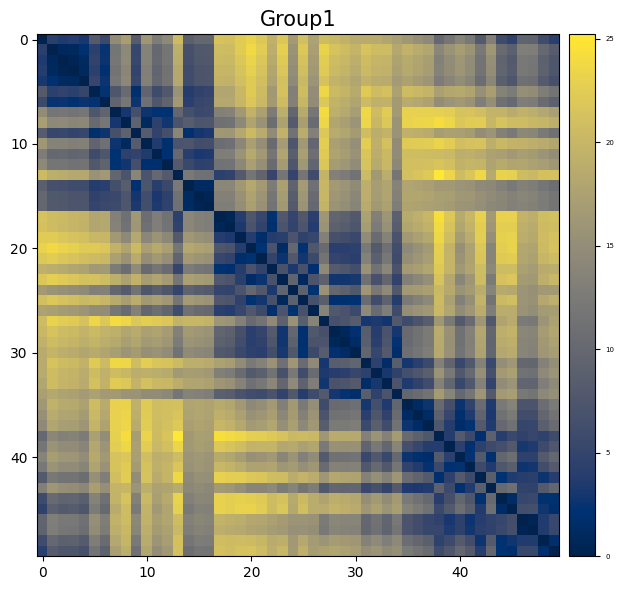

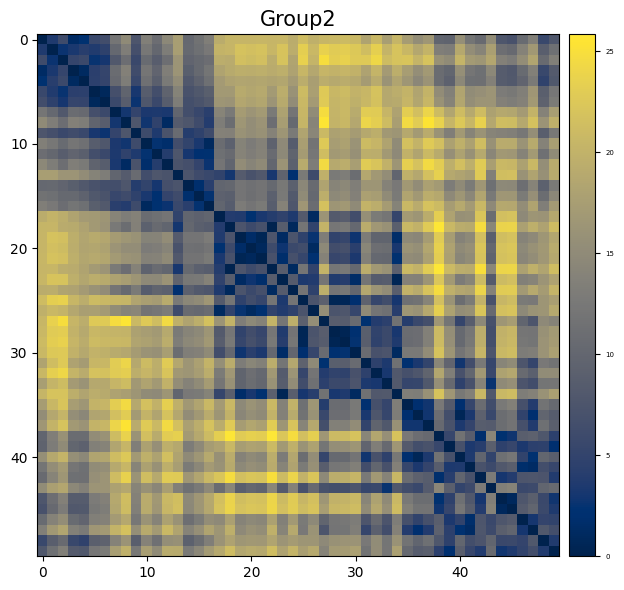

In [7]:
sim_mat_format = "default"

visualize_config = VisualizationConfig(
    figsize=(8, 6), 
    title_size = 15, 
    ot_object_tick=True,
)

visualize_hist = VisualizationConfig(figsize=(8, 6), color='C0')

sim_mat = align_representation.show_sim_mat(
    sim_mat_format = sim_mat_format, 
    visualization_config = visualize_config,
    visualization_config_hist = visualize_hist,
    show_distribution=False, # if True, the histogram figure of the sim_mat will be shown. visualization_config_hist will be used for adjusting this figure.
)

## Reperesentation Similarity Aanalysis (RSA)
This performs a conventional representation similarity analysis.

In [8]:
### parameters for computing RSA
# metric = "pearson" or "spearman" by scipy.stats
# method = "normal" or "all"
#     "normal" : perform RSA with the upper-triangle matrix of sim_mat
#     "all" : perform RSA with the full matrix of sim_mat
# The result of RSA for each pair will be stored in align_representation.RSA_corr
align_representation.RSA_get_corr(metric = "pearson", method = 'all')

# print(align_representation.RSA_corr)

Correlation Group1 vs Group2 : 0.9352717601425383


## GWOT
The optimization results are saved in the folder named "config.data_name" + "representations.name" vs "representation.name".  
If you want to change the name of the saved folder, please make changes to "config.data_name" and "representations.name" (or change the "filename" in the code block below).

GWOT is performed by appling the method `gw_alignment` to the instance of `AlignRepresentations` class.

We show all the parameters to run GWOT computation as an example with THINGS or DNN dataset because these dataset have category information label.

For the dataset of color, AllenBrain, and simulation (these doesn’t have the category information), we show how to do this in next cell. 

Here is the example to compute the GWOT for each pair for color, AllenBrain, and simulation datasets below.

In [9]:
visualize_config = VisualizationConfig(
    show_figure=True,
    figsize=(8, 6), 
    title_size = 15, 
    ot_object_tick=True,
    plot_eps_log=eps_log,
)

sim_mat_format = "default"

align_representation.gw_alignment(
    compute_OT = False,
    delete_results = False,
    return_data = False,
    return_figure = False,
    OT_format = sim_mat_format,
    visualization_config = visualize_config,
)

/home/oizumi/GitHub/GW_methods/src/align_representations.py:2097: UserWarning: numpy doesn't use GPU. Please 'multi_GPU = False'.
  warnings.warn("numpy doesn't use GPU. Please 'multi_GPU = False'.", UserWarning)
/home/oizumi/GitHub/GW_methods/src/align_representations.py:920: UserWarning: compute_OT is False, but this computing is running for the first time in the 'results_dir'.
  warnings.warn(
[I 2023-08-13 12:29:47,560] A new study created in RDB with name: simulation_1_Group1_vs_Group2_random


Study for simulation_1_Group1_vs_Group2_random was not found, creating a new one...


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-13 12:29:47,656] Trial 0 pruned. All iteration was failed with parameters: {'eps': 0.23688639503640782, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-13 12:29:49,075] Trial 1 finished with value: 6.090122834615989 and parameters: {'eps': 0.8927180304353626}. Best is trial 1 with value: 6.090122834615989.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-13 12:29:50,111] Trial 2 finished with value: 5.557786537433072 and parameters: {'eps': 0.5395030966670228}. Best is trial 2 with value: 5.557786537433072.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-13 12:29:51,539] Trial 3 finished with value: 6.517376155881763 and parameters: {'eps': 0.3968793330444371}. Best is trial 2 with value: 5.557786537433072.


# Step 4: Evaluation and Visualization
Finally, you can evaluate and visualize the unsupervise alignment of GWOT.   

## Show how the GWD was optimized
`show_optimization_log` will make two figures to show both the relationships between epsilons (x-axis) and GWD (y-axis), and between accuracy (x-axis) and GWD (y-axis).



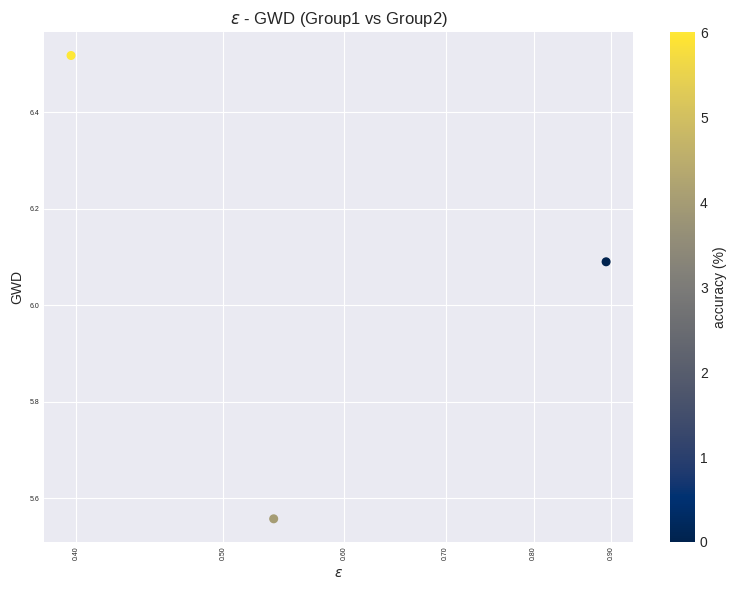

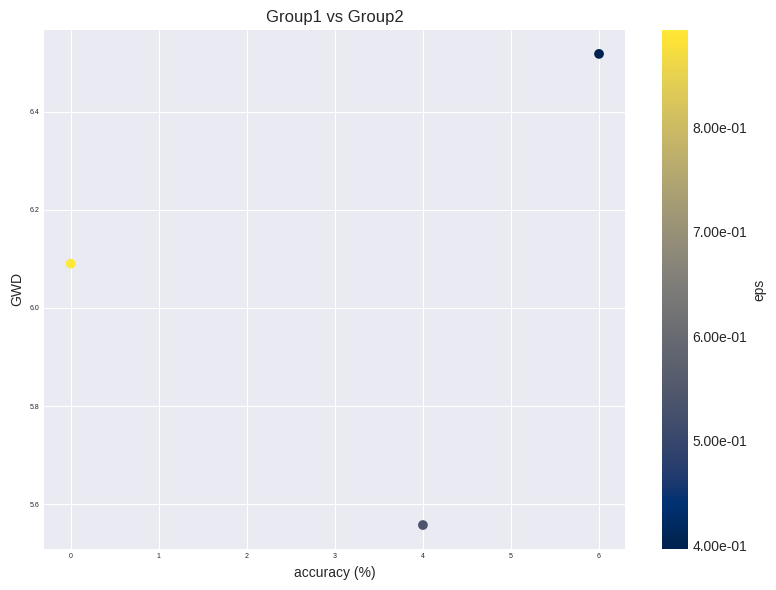

In [10]:
### Show how the GWD was optimized (evaluation figure)
# show both the relationships between epsilons and GWD, and between accuracy and GWD
align_representation.show_optimization_log(fig_dir=None, visualization_config=visualize_config) 

## Evaluation of the accuracy of the unsupervised alignment
There are two ways to evaluate the accuracy.  
1. Calculate the accuracy based on the OT plan. 
- For using this method, please set the parameter `eval_type = "ot_plan"` in "calc_accuracy()".
  
2. Calculate the matching rate based on the k-nearest neighbors of the embeddings.
-  For using this method, please set the parameter `eval_type = "k_nearest"` in "calc_accuracy()".

For both cases, the accuracy evaluation criterion can be adjusted by considering "top k".  
By setting "top_k_list", you can observe how the accuracy increases as the criterion is relaxed.

Top k accuracy : 
        Group1_vs_Group2
top_n                  
1                   4.0
5                  12.0
10                 22.0
Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


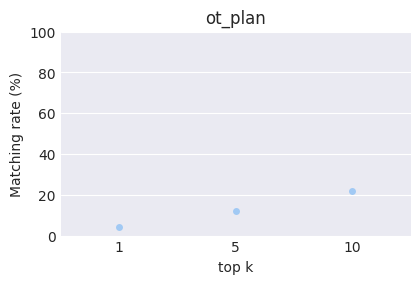

In [11]:
## Calculate the accuracy based on the OT plan. 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

top_k_accuracy = align_representation.top_k_accuracy # you can get the dataframe directly 

K nearest matching rate : 
        Group1_vs_Group2
top_n                  
1                   4.0
5                   8.0
10                 22.0
Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


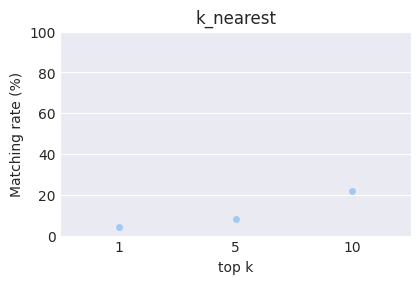

In [12]:
## Calculate the matching rate based on the k-nearest neighbors of the embeddings.
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

k_nearest_matching_rate = align_representation.k_nearest_matching_rate # you can get the dataframe directly 

## Visualize the aligned embeddings
Using optimized transportation plans, you can align the embeddings of each representation to a shared space in an unsupervised manner.  
The `"pivot"` refers to the target embeddings space to which the other embeddings will be aligned.   
You have the option to designate the `"pivot"` as one of the representations or the barycenter.  
Please ensure that 'pair_number_list' includes all pairs between the pivot and the other Representations.  

If you wish to utilize the barycenter, please make use of the method `AlignRepresentation.barycenter_alignment()`.  
You can use it in the same manner as you did with `AlignRepresentation.gw_alignment()`.

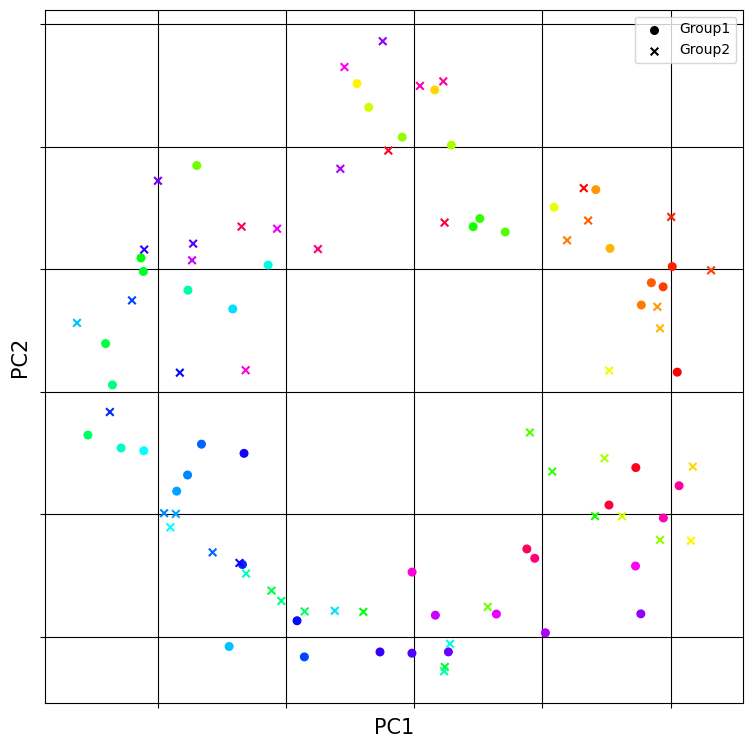

In [13]:
visualization_embedding = VisualizationConfig(
    figsize=(9, 9), 
    xlabel="PC1", 
    ylabel="PC2",
    legend_size=10
)

align_representation.visualize_embedding(
    dim=2, # the dimensionality of the space the points are embedded in. You can choose either 2 or 3.
    pivot=0, # the number of one of the representations or the "barycenter".
    visualization_config=visualization_embedding
)